In [4]:
#!/usr/bin/env python
import argparse
import builtins
import os
import shutil
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.models as models

import sys
sys.path.extend(['..', '.'])
from datasets.dataset_tinyimagenet import load_train, load_val_loader, num_classes_dict
from tools.store import ExperimentLogWriter
import models.builder as model_builder
import utils

from sklearn.cluster import KMeans
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
model_names += ['resnet18_cifar_variant1']

args = argparse.Namespace(
    dataset='cifar10',
    arch='resnet18_cifar_variant1',
    workers=1,
    epochs=100,
    start_epoch=0,
    batch_size=256,
    lr=30.0,
    schedule=[60, 80],
    momentum=0.9,
    weight_decay=0.0,
    print_freq=10,
    evaluate=False,
    world_size=-1,
    rank=-1,
    dist_url='tcp://224.66.41.62:23456',
    dist_backend='nccl',
    seed=None,
    gpu=None,
    multiprocessing_distributed=False,
    opt='sgd',
    dir='log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20',
    num_per_class=int(1e10),
    val_every=5,
    latest_only=True,
    mpd=False,
    dist_url_add=0,
    specific_ckpts=None,
    use_random_labels=False,
    normalize=False,
    nomlp=True,
    aug='standard',
    download=True
)


In [5]:
# Check if the file exists
file_path = "data/embeddings.pt"
if not os.path.exists(file_path):
    print("Embeddings file not found.")
else:
    # Load the embeddings tensor from the file
    embeddings = torch.load(file_path)

    # Print the shape or any other desired information about the loaded embeddings
    print("Loaded embeddings shape:", embeddings.shape)

Loaded embeddings shape: torch.Size([50000, 512])


In [6]:
num_classes = 10
num_clusters = num_classes

In [7]:
kmeans_10 = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

/Users/jinhuang/opt/miniconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
def load_labels(train_loader):
    labels = []
    for _, label in train_loader:
        labels.extend(label.tolist())
    return labels

In [9]:
# Load and build the model
# loop through checkpoints and set pre-trained
ckpt_dir = os.path.join(args.dir, 'checkpoints')
for fname in sorted(os.listdir(ckpt_dir)):
    if args.latest_only and not fname.startswith('latest_'): continue
    if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
    args.pretrained = os.path.join(ckpt_dir, fname)
args.distributed = False

model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
# load from pre-trained, before DistributedDataParallel constructor
if args.pretrained:
    if os.path.isfile(args.pretrained):
        checkpoint = torch.load(args.pretrained, map_location='cpu')
        state_dict = checkpoint['state_dict']
        model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
    else:
        print("=> no checkpoint found at '{}'".format(args.pretrained))

=> loading checkpoint 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'
=> loaded pre-trained model 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'


In [10]:
random_labels = None
train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                         args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)

# Load original labels
original_labels = load_labels(train_loader)
    

## Sanity check for correctness of embeddings

In [15]:
print(f"original embeddings: {embeddings}")

original embeddings: tensor([[0.0010, 0.0055, 0.0000,  ..., 0.0060, 0.0049, 0.0037],
        [0.0101, 0.0169, 0.0148,  ..., 0.0000, 0.0096, 0.0169],
        [0.0066, 0.0076, 0.0027,  ..., 0.0000, 0.0002, 0.0017],
        ...,
        [0.0005, 0.0125, 0.0016,  ..., 0.0000, 0.0026, 0.0072],
        [0.0096, 0.0090, 0.0057,  ..., 0.0004, 0.0002, 0.0028],
        [0.0027, 0.0026, 0.0015,  ..., 0.0006, 0.0014, 0.0252]])


In [17]:
def get_embeddings_and_labels(model, dataloader, device):
    # Copy the model without its last layer
    embedding_model = nn.Sequential(*(list(model.children())[:-1]))
    embedding_model = embedding_model.to(device)

    # Set the model in evaluation mode
    embedding_model.eval()

    # Initialize an empty tensor to store all the embeddings and labels
    all_embeddings = torch.empty((0, 512)).to(device)
    all_labels = torch.empty(0, dtype=torch.long).to(device)

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            print(i)
            images = images.to(device)
            labels = labels.to(device)

            # Get embeddings for this batch and flatten them
            embeddings = embedding_model(images).view(images.size(0), -1)

            # Concatenate with the previous embeddings and labels
            all_embeddings = torch.cat((all_embeddings, embeddings))
            all_labels = torch.cat((all_labels, labels))

    return all_embeddings, all_labels


In [18]:
new_embeddings, new_labels = get_embeddings_and_labels(model, train_loader, 'cpu')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195


## Verify the labels and embeddings

In [20]:
def verify_embeddings(new_embeddings, embeddings, new_labels, original_labels):
    # Check if new_embeddings match with the embeddings for all indices
    for i in range(len(new_embeddings)):
        if not torch.allclose(embeddings[i], new_embeddings[i], atol=1e-7):
            print("New embeddings do not match with the embeddings at index", i)
            print("New embedding:", new_embeddings[i])
            print("Original embedding:", embeddings[i])
            return False

    print("New embeddings match with the embeddings.")

    # Check if new_labels match with the original_labels for all indices
    for i in range(len(new_labels)):
        if new_labels[i] != original_labels[i]:
            print("New labels do not match with the original labels at index", i)
            print("New label:", new_labels[i])
            print("Original label:", original_labels[i])
            return False

    print("New labels match with the original labels.")
    return True

# Verify the embeddings and labels
verify_embeddings(new_embeddings, embeddings, new_labels, original_labels)


New embeddings do not match with the embeddings at index 0
New embedding: tensor([8.1854e-04, 1.3397e-02, 0.0000e+00, 1.7272e-02, 1.9156e-02, 3.0403e-03,
        0.0000e+00, 0.0000e+00, 1.5362e-02, 1.1454e-02, 8.1999e-04, 1.9657e-02,
        1.9951e-03, 6.1089e-03, 1.2618e-02, 6.7193e-04, 1.0880e-02, 3.9578e-05,
        2.2172e-02, 2.2023e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3891e-02,
        9.7834e-03, 2.9336e-03, 6.1568e-04, 7.0543e-03, 0.0000e+00, 9.3882e-04,
        4.7415e-03, 3.9550e-03, 0.0000e+00, 9.8832e-03, 7.6521e-02, 0.0000e+00,
        0.0000e+00, 2.2030e-02, 0.0000e+00, 0.0000e+00, 5.9088e-03, 0.0000e+00,
        3.2315e-02, 0.0000e+00, 4.1303e-03, 0.0000e+00, 1.2340e-02, 0.0000e+00,
        4.3035e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.5077e-03, 2.1561e-02,
        3.0017e-03, 0.0000e+00, 9.3297e-03, 1.0403e-04, 3.2029e-02, 1.4469e-03,
        3.1546e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3993e-03, 1.0203e-02,
        2.2548e-03, 4.5582e-03, 1.2535e-02, 3.

False

## Visualize the clusters

In [21]:
# Reduce dimensionality for visualization
embeddings_2d = TSNE(n_components=2).fit_transform(new_embeddings)

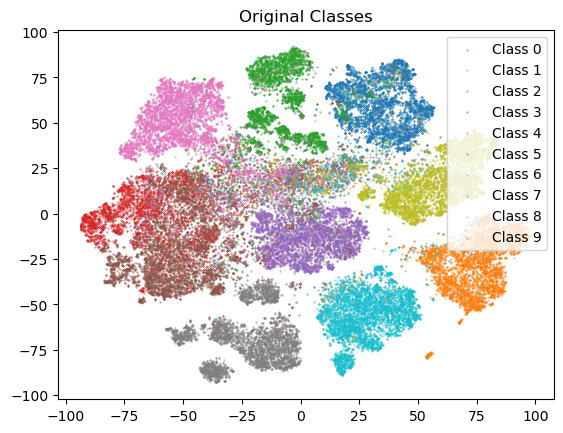

In [25]:
%matplotlib inline
# Create a scatter plot with original labels
for label in set(original_labels):
    indices = np.where(np.array(new_labels) == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Class {label}", s=0.1)  # Set s to a smaller value, such as 10

plt.title("Original Classes")
plt.legend()
plt.show()